### Introduction

Proteins are fluctuating macromolecular systems. Their conformational repertoire can be linked to functional properties by careful examination of their thermodynamic and kinetic properties. Experimental techniques can access relevant conformations for protein function that can be further studied by employing computational experiments. Methods like molecular dynamic simulations generate more detailed conformational ensembles that can shed light into how dynamic processes are manifested at the molecular level. 

In this tutorial we use two explicit conformations of bacterial Adenylate Kinase (AK) to set up a dual-basin potential. This will help to evaluate conformational transitions between the open and close configurations for this enzymatic system.

### Requirements 

- [OpenMM python API](http://openmm.org/)
- [sbmOpenMM library](https://bitbucket.org/compbiochbiophlab/sbm-openmm/src)
- [MDTraj library](http://mdtraj.org/)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)
- [PyWham](http://pywham.net/)

### Setting a multi-basin SBM using a coarse grained (CA) model

The first step of this tutorial will be to create two single basin potential from the open and close configurations of AK. The input structures are in the input folder of the root directory of this tutorial. We import OpenMM and the sbmOpenMM library.

In [1]:
# Import OpenMM library
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *

# Import sbmOpenMM library
import sbmOpenMM

Let's define the paths to the pdb and contacts files:

In [2]:
# Define input PDB files for open and closed conformations of AK.
input_pdb_open = 'input/AK_open.pdb'
input_pdb_close = 'input/AK_close.pdb'

#Define input contacts files for open and closed conformations of AK.
input_contacts_open = 'input/AK_open_CA.contacts'
input_contacts_close = 'input/AK_close_CA.contacts'

Now we load the CA SBMs using the getCAModel() method from the sbmOpenMM.models class:

In [3]:
# Build sbmOpenMM.system  class for the open and close conformation.
sbmModel_open = sbmOpenMM.models.getCAModel(input_pdb_open, input_contacts_open)
sbmModel_close = sbmOpenMM.models.getCAModel(input_pdb_close, input_contacts_close)

Generating CA SBM for PDB file input/AK_open.pdb

Setting up geometrical parameters:
_________________________________
Keeping only carbon alpha atoms in topology
Added 214 CA atoms
Added 213 bonds
Added 212 angles
Added 211 torsions
Reading contacts from contact file: input/AK_open_CA.contacts
Added 597 native contacts

Setting up default forcefield parameters:
________________________________________
Adding default bond parameters:
Adding default angle parameters:
Adding default torsion parameters:
Adding default contact parameters:

Adding Forces:
_____________
Added Harmonic Bond Forces
Added Harmonic Angle Forces
Added Periodic Torsion Forces
Added Lennard Jones 12-10 Forces to native contacts
Added Lennard Jones 12 non-bonded Forces

Creating System Object:
______________________
The Potential Energy of the system is : -587.9515380859375 kJ/mol
The Harmonic Bond Energy is: 5.799805080641818e-09 kj/mol
The Harmonic Angle Energy is: 2.4016344468691386e-10 kj/mol
The Periodic Torsio

Before creating our multi basin SBM it would be very informative to know how these two configurations differ between each other. This is completely optional and is not necessary for generating multi basin potentials. We assert that the number of geometric parameters are equivalent between the configurations. 

In [4]:
# Use assert() function to compare the number of geometrical paramaters in each model.
assert sbmModel_open.n_atoms == sbmModel_close.n_atoms
assert sbmModel_open.n_bonds == sbmModel_close.n_bonds
assert sbmModel_open.n_angles == sbmModel_close.n_angles
assert sbmModel_open.n_torsions == sbmModel_close.n_torsions

We notice that all geometrical parameters (particles, bonds, angles and torsions) have the same number, which is to be expected given that we have the same protein system only differing at the conformation. We need to further compare that both SBM models contain exactly the same bond definitions. We iterate every bond and compare the atom indexes for each model.

Note that bonds are stored in the "bonds" attribute of the sbmOpenMM.system() class, which is the returned initialized class by the sbmOpenMM.models.getCAModel() method (e.g. the sbmModel_open and sbmModel_close objects). We also can access the indexes of these bonds with the attribute "bonds_indexes". The total number of bonds is stored in the "n_bonds" attribute. For more information on how information is stored in the sbmOpenMM.system class consult the [sbmOpenMM documentation](https://compbiochbiophlab.github.io/sbm-openmm) or use help() upon the python object of interest.

In [5]:
# Loop over the number of bonds in the conformations.
for i in range(sbmModel_open.n_bonds): 
    # Assert if their bond indexes are the same
    assert sbmModel_open.bonds_indexes[i] == sbmModel_close.bonds_indexes[i]

We see that all bonds are defined equally in both conformations. Since the possible angles and torsions are derived from the bonding connectivity, we can safely assume that they will also match their definitions between the configurations.

We can now proceed to compare bonds, angles and torsions by means of plotting their differences between configurations. We import numpy and matplotlib:

In [6]:
import numpy as np
import matplotlib.pyplot as plt

First, we calculate the absolute differences between the bond distances in each configuration. The bond parameters are stored in the "bonds" attribute, which is a dictionary that uses 2-tuples atom objects ([openmm Atom](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.app.topology.Atom.html)) as keys. These 2-tuples correspond to the pair of atoms forming each bond. The values returned by this dictionary are 2-tuples containing the parameters of the SBM force field bonded function (i.e. [openmm HarmonicBondForce](http://docs.openmm.org/7.0.0/api-python/generated/simtk.openmm.openmm.HarmonicBondForce.html)). The first element is a [quantity object](http://docs.openmm.org/development/api-python/generated/simtk.unit.quantity.Quantity.html) storing the bond length and the second element is a float number storing the force constant of the harmonic bond force.

0.01567092472049375


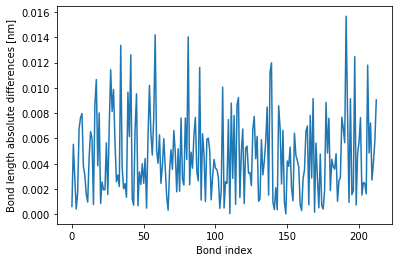

In [7]:
# Store the bonds lengths into numpy arrays
r_open = np.array([sbmModel_open.bonds[b][0]._value for b in sbmModel_open.bonds]) # note we use ._value() to only extract the scalar values. 
r_close = np.array([sbmModel_close.bonds[b][0]._value for b in sbmModel_close.bonds])

# Calculate the bond absolute differences and plot them
plt.plot(np.absolute(r_open - r_close))
plt.xlabel('Bond index')
plt.ylabel('Bond length absolute differences [nm]')
print(np.amax(np.absolute(r_open - r_close))) # Print the maximum difference

The larger difference in the bond lengths is of 0.0157 nanometer, which is insignificantly small. By a similar procedure we plot the angles absolute differences between the conformations:

Maximum: 19.34
Average: 3.94
St. Dev.: 3.69


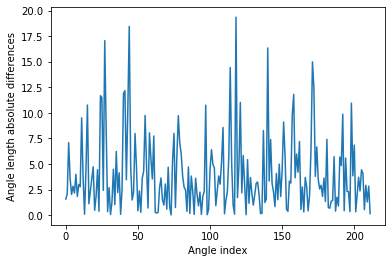

In [8]:
# Store the angles length values into numpy arrays
a_open = np.array([sbmModel_open.angles[a][0]._value for a in sbmModel_open.angles]) # note we use ._value() to only extract the scalar values. 
a_close = np.array([sbmModel_close.angles[a][0]._value for a in sbmModel_close.angles])

#Calculate the angles absolute differences and plot them
plt.plot(np.degrees(np.absolute(a_open - a_close))) # Convert differences into degrees before plotting
plt.xlabel('Angle index')
plt.ylabel('Angle length absolute differences')
print('Maximum: %.2f' % np.amax(np.degrees(np.absolute(a_open - a_close)))) # Print the maximum difference
print('Average: %.2f' % np.average(np.degrees(np.absolute(a_open - a_close)))) # Print the average difference
print('St. Dev.: %.2f' % np.std(np.degrees(np.absolute(a_open - a_close)))) # Print the standard deviataion of the differences

The largest difference between the angles is about 20 degrees, with most of the values having low angle differences. This means that there are changes in angular geometries when shifting conformations, although they are not very large.

We now move to compare torsional values. Because we are using a coarse grained model for the configurations we expect to have R - 3 torsions for the protein, where R is the number of amino acid residues. We use an analogous procedure as before to compare the torsion dihedrals. However, we need to be careful of how we compute this differences. Generally, torsions are defined to be between -180 to 180 degrees, which numerically can give large difference if the periodicity of the torsion is not considered (e.g. 180-\[-180\]=360). To avoid this we use the signed angle difference between the torsion angles:

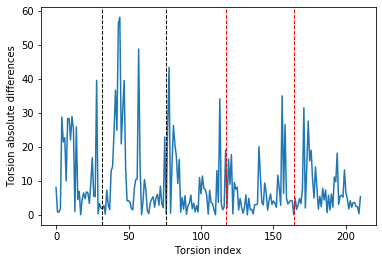

In [9]:
# Store the torsion angles length values into numpy arrays
t_open = np.array([sbmModel_open.torsions[t][0]._value for t in sbmModel_open.torsions]) # note we use ._value() to only extract the scalar values. 
t_close = np.array([sbmModel_close.torsions[t][0]._value for t in sbmModel_close.torsions])

#Calculate the torsion absolute differences
t_diff = np.degrees(t_open) - np.degrees(t_close) # Simple torsion differences in degrees
t_diff = np.absolute((t_diff + 180) % 360 - 180) # Signed angle torsion differences

#Plot the differences
plt.plot(t_diff)
plt.xlabel('Torsion index')
plt.ylabel('Torsion absolute differences')
plt.axvline(32, c='k', ls='--', lw=1) # Plot region 1, for details see below
plt.axvline(76, c='k', ls='--', lw=1) # Plot region 1
plt.axvline(117, c='r', ls='--', lw=1) # Plot region 2
plt.axvline(164, c='r', ls='--', lw=1) # Plot region 2

As we could expect large differences are found at the torsion equilibrium values between both configurations. If we structurally align both conformations we would see that two regions won't superimpose; region 1: residues 32 to 76 (black vertical lines) and region 2: residues 117 to 164 (red vertical lines). These two regions define the open and close conformations for AK; in the open conformation these regions are outwardly bent exposing to solvent a big surface in the protein, while in the close conformation region 2 closes and interacts with region 1, locking-in the close conformation. We see that large torsional differences appear inside region 1, but not necessarily in region 2. Many other large torsional changes are found outside the not-superimposing regions (i.e. region 1  and 2) of the protein. We could hypothesize that concerted torsional variations outside these regions are also necessary to carry out the conformational shift.

The following movie interpolates the structural change between configurations. Here, it is clear how region 1 (right - light blue) and 2 (up - green/yellow) interact to form the close conformation.

In [10]:
from IPython.display import HTML

HTML("""
    <video alt="AK_conformationalChange" controls>
        <source src="input/AK_conformationalChange.webm" type="video/webm">
    </video>
""")

We now create the multi-basin model for these two configurations. Using the [sbmOpenMM.models.getMultiBasinModel()](https://compbiochbiophlab.github.io/sbm-openmm/build/html/index.html#sbmopenmm-models) method we use the open conformation as our main configuration and the close conformation as our alternate configuration. The method generates a multi basin potential only at the native contact level, the rest of the forcefield parameters are copied from the main configuration. This means that bonds, angles and torsions are kept as in the main configuration (open conformation) and a contact analysis is executed to include native contacts from the alternate configuration (close conformation).

In [11]:
sbmModel_dual = sbmOpenMM.models.getMultiBasinModel(sbmModel_open, alternate_configuration=sbmModel_close)

Creating Multi Basin Potential

Contact analysis:
________________
Contacts in main configuration: 597
Contacts in alternate configuration: 635
Common contacts between configurations: 522
Common contacts with an equilibrium distance difference larger than 0.05 nm: 154
Unique contacts in main configuration: 75
Unique contacts in alternate configuration: 113
Total contacts in multi basin potential: 710

Adding Forces:
_____________
Adding Harmonic Bond Forces
Adding Harmonic Angle Forces
Adding Periodic Torsion Forces
Adding Lennard Jones 12-10 potential to single minimum contacts
Adding Gaussian potential to double minimum contacts
Adding repulsion Lennard Jones 12 potential for non native contacts

Creating System Object:
______________________
The Potential Energy of the system is : -636.065673828125 kJ/mol
The Harmonic Bond Energy is: 5.799805080641818e-09 kj/mol
The Harmonic Angle Energy is: 2.4016344468691386e-10 kj/mol
The Periodic Torsion Energy is: 6.854534149169922e-07 kj/mol
T

In the contact analysis we see that the open conformation has 597 contacts, while the close one has 635. 522 contacts are shared among the conformations, but only 154 are larger than a default threshold, of 0.5 Angstroms, to be treated as double minima. Finally, 75 contacts are unique to the open conformation and 113 to the close one. The resulting dual basin model has a total of 710 native contacts. 

Note that Lennard-Jones potential are used as default for all non-dual basin contacts. It is possible to change this behavior by giving the option 'use_lennard_jones = False', this will model all the non-bonded interactions with a Gaussian potential.

We now proceed to simulate the multi basin SBM model. We need to use a high enough temperature to observe transitions between the open and close configurations, but not to high to avoid denaturating the protein, which will expose the unfolded state. For this dual-basin system the unfolding temperature was estimated to be $T_f=165 REU$, therefore, we expect to see unfolding of the protein, with high enough probability, using this or higher temperatures. We are going to employ $0.75T_F$ as our target temperature for exploring transitions between the configurations. To test this we are going to simulate 10 replicas during 10 nanoseconds each. 

In [12]:
import time

#Set temperature to Tf*0.75
T_f = 165
temperature = 0.75 * T_f

#Define a loop with the number of replicas we wish to run.
for replica in range(10):
    
    #Define the name of the energy file for each replica
    energy_file = 'energy_'+str(replica+1).zfill(2)+'.data'
    
    #Define the name of the trajectory file for each replica
    trajectory_file = 'traj_'+str(replica+1).zfill(2)+'.dcd'
    
    #Define the integrator and context for the simulation at the defined temperature
    integrator = LangevinIntegrator(temperature, 1/picosecond, 0.5*femtoseconds)
    simulation = Simulation(sbmModel_dual.topology, sbmModel_dual.system, integrator)
    
    #Set the initial coordinates
    simulation.context.setPositions(sbmModel_dual.positions)
    
    #Add a SBM reporter that writes energies every 1 picosecond = 2000 steps (at 0.5 fs timestep).
    simulation.reporters.append(sbmOpenMM.sbmReporter(energy_file, 2000, sbmObject=sbmModel_dual,
                                                  step=True, potentialEnergy=True, temperature=True))
    
    #Add a DCD reporter that writes coordinates every 1 picosecond = 2000 steps (at 0.5 fs timestep).
    simulation.reporters.append(DCDReporter(trajectory_file, 2000))
    
    #Run each simulation for 10 ns = 20 million steps.
    start_time = time.time()
    simulation.step(20000000)
    
    print("--- Finished simulation for replica %s in %s seconds ---" % (replica+1, (time.time() - start_time)))

--- Finished simulation for replica 1 in 428.19062995910645 seconds ---
--- Finished simulation for replica 2 in 428.119491815567 seconds ---
--- Finished simulation for replica 3 in 428.6434578895569 seconds ---
--- Finished simulation for replica 4 in 431.0667815208435 seconds ---
--- Finished simulation for replica 5 in 433.3968918323517 seconds ---
--- Finished simulation for replica 6 in 678.4710323810577 seconds ---
--- Finished simulation for replica 7 in 431.3924400806427 seconds ---
--- Finished simulation for replica 8 in 423.51778531074524 seconds ---
--- Finished simulation for replica 9 in 422.43618273735046 seconds ---
--- Finished simulation for replica 10 in 426.02728056907654 seconds ---


To visualize the progress of the simulations we need to distinguish between the open and close conformations. The simpler approach will be to project the simulations into coordinates containing only unique contacts to each conformation. The multi basin SBM model contains special attributes that store these special sets of contacts:

- common_contacts: contains the set of common contacts between both configurations.

- dual_basin_contacts: contains the set of common contacts for which a dual basin potential has been set up.

- unique_contacts[0]: contains the set of unique contacts of the main configuration.

- unique_contacts[1]: contains the set of unique contacts of the alternate configuration.

We are going to employ these two last sets to calculate the number of native contacts unique to each conformation.

Let us import mdtraj to analyze the simulations:

In [13]:
import mdtraj as md

To calculate the number of native contacts formed we will compute the contact distances at each trajectory frame. Distances lower or equal than the equilibrium lengths (i.e. formed contacts) are estimated using an error parameter to lax the distance requirement for contact formation.

Once the number of unique contacts formed for each configuration are counted, each frame will be represented by a pair (i,j), where i is the number of unique contacts formed for the open conformation and j is the number of unique contacts formed for the close conformation. We store this information in a matrix by counting the number of (i,j) frames during all the simulated data.

Text(78, 45, 'B')

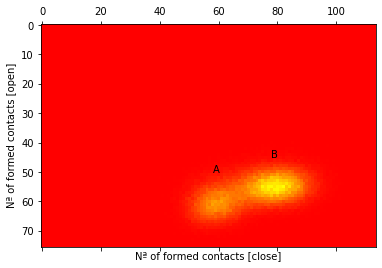

In [14]:
# Load open and close conformations as mdtraj trajectories
open_conformation = md.load('open_conformation.pdb')
close_conformation = md.load('close_conformation.pdb')

# Define error parameter as 15%
error = 1.15

# Calculate the equilibrium distances for the open conformation contacts
open_reference_distances = md.compute_distances(open_conformation, sbmModel_dual.unique_contacts[0]) * error # Here we introduce the error
close_reference_distances = md.compute_distances(close_conformation, sbmModel_dual.unique_contacts[1]) * error

# Create a matrix to store the trajectory (i,j) contacts counts
# The shape of the matrix is defined as the number of unique contacts for each configuration: (75,113)
contact_counts = np.zeros((len(sbmModel_dual.unique_contacts[0])+1, len(sbmModel_dual.unique_contacts[1])+1)) # We add one to include the zero contacts option

# Define a loop with the number of replicas we wish to analyse.
for replica in range(10):
    
    # Define the name of the trajectory file for each replica
    trajectory_file = 'traj_'+str(replica+1).zfill(2)+'.dcd'
    
    # Load simulated trajectories with mdtraj
    trajectory = md.load(trajectory_file, top='open_conformation.pdb') # Here we can use any conformation as topology
    
    # Calculate the equilibrium contact distances for the open and close conformations
    open_distances = md.compute_distances(trajectory, sbmModel_dual.unique_contacts[0])
    close_distances = md.compute_distances(trajectory, sbmModel_dual.unique_contacts[1])   
    
    # Calculate and count the number of contact distances lower or equal to the reference distances
    open_contacts = np.count_nonzero(np.where(open_distances <= open_reference_distances, open_distances, 0), axis=1)
    close_contacts = np.count_nonzero(np.where(close_distances <= close_reference_distances, close_distances, 0), axis=1)
    
    # Iterate over the pair of contact counts
    for i in zip(open_contacts, close_contacts):
        
        #Count the pairs in the contact_counts matrix
        contact_counts[i[0]][i[1]] += 1

# Plot the contact count matrix
plt.matshow(contact_counts, cmap=plt.cm.autumn)
plt.xlabel('Nª of formed contacts [close]')
plt.ylabel('Nª of formed contacts [open]')
plt.text(58, 50, 'A') # Label manually the location of minimum A
plt.text(78, 45, 'B') # Label manually the location of minimum B

There are two visible minima in our exploration. Minimum A corresponds to the open conformation and B to the close one. These minima have contacts from both configurations formed simultaneously, although they are enriched in one specific set. From these simulations we observe that minimum B is wider and more populatedthan minimum B. Is interesting that the close configuration seems to be more stable at the simulated conditions even when we employed angles and torsions from the open configuration. In this case it seems that the number of native contacts of the configuration has a dominant role over the explored conformational space. It is important to remark that this is an exercise study, and not careful consideration was payed to reproduce experimental conditions in order to validate this model.

Finally, we are going to calculate a free energy profile using the simulated data. Take into account that the simulation times are extremely short to arrive at any thorough conclusion!.

As in the [free energy tutorial](https://github.com/CompBiochBiophLab/sbm-openmm/blob/master/tutorials/basic/04-FreeEnergySurface/freeEnergyProfile.ipynb) we are going to use PyWham to estimate the free energy profiles. For this we write the simulation data into files, the data we need is the potential energy of each frame and the fraction of unique native contacts ($Q_f$) for each conformation.

We employ a function to read the OpenMM energy files into numpy arrays:

In [15]:
import numpy as np

def readOpenMMReporterFile(reporter_file):
    #Open the reporter file
    with open(reporter_file, 'r') as ef:
        #Store the lines 
        lines = ef.readlines()
        #Define a dictionary to store the data
        data = {}
        #read the header and create for each term an entry for the dictionary initialised to a list
        for r in lines[0].split(','):
            data[r.replace('#','').replace('"','').strip()] = []
        #read each value in the file and store it in the dictionary's lists.
        for i,r in enumerate(data):
            for line in lines[1:]:
                #Convert the read string into a float for easy processing of numerical data
                data[r].append(float(line.strip().split(',')[i]))
                
        #Convert each list into a numpy array
        for entry in data:
            data[entry] = np.array(data[entry])
            
    #return the created dictionary
    return data

Now we save the data into files having three columns of data without headers:
    
Potential Energy, $Q_fclose$, $Q_f open$

In [16]:
#Create a list to store the paths of the output files
output_files = []

#Create the output folder if it does not exists
folderName = 'simulationData'
if not os.path.exists(folderName):
    os.mkdir(folderName)
    
# Define a loop with the number of replicas we wish to read the data from.
for replica in range(10):
    
        ## Extract potential energy values from the energy file ##
    
    # Define the name of the energy file for each temperature
    energy_file = 'energy_'+str(replica+1).zfill(2)+'.data'
    
    # Read the energy data from each energy file
    simulationData = readOpenMMReporterFile(energy_file)
    
    # Store the potential energy numpy array into a variable
    V = simulationData['Potential Energy (kJ/mole)']
    
        ## Extract potential energy values from the energy file ##
    
    # Define the name of the trajectory file for each replica
    trajectory_file = 'traj_'+str(replica+1).zfill(2)+'.dcd'
    
    # Load simulated trajectories with mdtraj
    trajectory = md.load(trajectory_file, top='open_conformation.pdb')
    
    # Calculate the equilibrium contact distances for the open and close conformations
    open_distances = md.compute_distances(trajectory, sbmModel_dual.unique_contacts[0])
    close_distances = md.compute_distances(trajectory, sbmModel_dual.unique_contacts[1])   
    
    # Calculate the number of contact distances lower or equal to the references.
    open_contacts = np.count_nonzero(np.where(open_distances <= open_reference_distances, open_distances, 0), axis=1)
    close_contacts = np.count_nonzero(np.where(close_distances <= close_reference_distances, close_distances, 0), axis=1)
    
    # Convert to fration of native contacts dividing by the total number of contacts
    qf_open = open_contacts/ len(sbmModel_dual.unique_contacts[0])
    qf_close = close_contacts/ len(sbmModel_dual.unique_contacts[1])
    
        ## Write simulation data to file ##
    
    #Define the path name of the outputfile
    fileName = folderName+'/Qf_'+str(replica+1).zfill(2)+'.data'
    
    #Write data as columns into the output file
    with open(fileName, 'w') as wf:
        for i in range(trajectory.n_frames):
            wf.write('%f %.4f %.4f\n' % (V[i], qf_open[i], qf_close[i]))
            
    #Append the output file name to the output_files list
    output_files.append(fileName)

Now we execute PyWham using the xml file given in the input folder. The output file is called 'fe.dataT123.75', which contains the estimated free energy profile using the WHAM method. We read the file and convert the data into a matrix format to plot it with matplotlib:

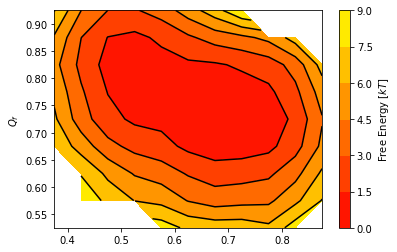

In [17]:
#Create lists to store the calculated values.
Qf_open = []
Qf_close = []

#Read the PyWham free energy output file
with open('fe.dataT123.75', 'r') as f:
    
    #Save all lines into a variable to be read more than once
    lines = f.readlines()
    
    #Iterate over the lines to store the values of Qf and RMSD
    for line in lines:
        ls = line.strip().split()
        Qf_open.append(float(ls[0])) # First column contains Qf open coordinate
        Qf_close.append(float(ls[1])) # Second column contains Qf close coordinate
    
    #Create list of sets of the coordinates to extract only the unique values orderly
    Qf_open_values = sorted(list(set(Qf_open)))
    Qf_close_values = sorted(list(set(Qf_close)))
    
    #Count the number of different values for each coordinate
    n_Qf_open_values = len(Qf_open_values)
    n_Qf_close_values = len(Qf_close_values)
    
    #Create a matrix to store the free energy values
    free_energy = np.zeros((n_Qf_open_values, n_Qf_close_values))
    
    #Fill matrix with nan to show missing values with a different color
    free_energy[:] = np.nan
    
    #Iterate again over the lines to get the indexes where to store the free energy values
    for line in lines:
        ls = line.strip().split()
        i = Qf_open_values.index(float(ls[0]))    # Matrix index for Qf open coordinate
        j = Qf_close_values.index(float(ls[1]))  # Matrix index for  Qf close coordinate
        free_energy[i,j] = float(ls[2])      # The third line contains the free energy
        
    #Set the lower minimum of the free energy profile to zero
    free_energy = free_energy- np.nanmin(free_energy)
    
#Plot the free energy matrix
plt.contour(Qf_close_values, Qf_open_values, free_energy,  colors='black')  
plt.contourf(Qf_close_values, Qf_open_values, free_energy,  cmap='autumn')
plt.ylabel('$Q_f$')
plt.colorbar(label='Free Energy [$kT$]')

We see that the free energy plot contains only one large minimum. This is probably an artifact of the plotted contour levels, distanced by 1.5 units, which is not enough separation to distinguish the minima. If we define explicitly the levels to draw we can include lower contour values to visualize them clearly as separate basins:

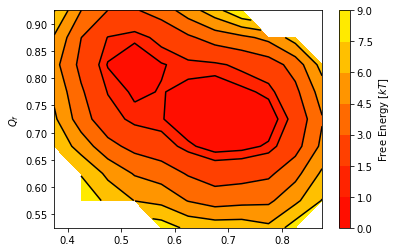

In [18]:
#Plot the free energy matrix
lines = [0, 1.0, 1.5, 3.0, 4.5, 6.0, 7.5, 9.0]
plt.contour(Qf_close_values, Qf_open_values, free_energy,  colors='black', levels=lines)  
plt.contourf(Qf_close_values, Qf_open_values, free_energy,  cmap='autumn', levels=lines)
plt.ylabel('$Q_f$')
plt.colorbar(label='Free Energy [$kT$]')

We defined an extra contour line at 1 kT that indeed separates the two minima. This shows that the free energy of interconversion of these two configurations is very low at the simulated conditions.

## Summary

We explored a coarse grained dual basin potential for the AK protein system. Two configurations,  an open and a close conformation, were compared at the bond, angle and torsional level to see which geometric characteristic dominated their difference. The dual basin potential was constructed from two alpha-carbon models, initialized from different structure and native contact files. This model was used to simulate transitions between the two configuration by running 10 replicas at $0.75T_f$. The simulated data was used to derive a free energy profile that shows a very low barrier of interconversion at this temperature. 